# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [146]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer

from ruzicka.test_metrics import nini, minmax, cosine


In [23]:
nini9 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(9, 9),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)

In [174]:
ngram = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 5),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
    # Never centre the data for use with minmax distance!
    StandardScaler(with_mean=False),
)

In [24]:
lenc = LabelEncoder()

In [142]:
vecs = pd.read_csv('elegy_corpus.csv', index_col=0)
non_elegy_vecs = pd.read_csv('non_elegy_corpus.csv',index_col=0)

In [143]:
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...


In [25]:
corpus = pd.concat([vecs, non_elegy_vecs])

In [62]:
test_corpus = corpus[corpus.Author != 'ps-Ovid']
test_corpus = test_corpus[test_corpus.LEN >= 20]
test_corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
195,V.Flaccus,195-Argonautica,195-Argonautica,98,si pelopis duros prior hippodamia labores\neks...
196,Lucretius,196-DRN,196-DRN,93,dekiderunt kwo_kwet in talis wenere meatus\nkw...
197,Horace,197-Hor.,197-Hor. Sat.,94,eksirem plures kalones atkwe kaballi\npaskendi...
198,Vergil,198-Aeneid,198-Aeneid,106,in lukem genito_ramyko dedit et fake praenjas\...


In [27]:
problems = corpus[corpus.Author == 'ps-Ovid']

In [175]:
X = ngram.fit_transform(test_corpus.Chunk)
y = lenc.fit_transform(test_corpus.Author)

In [137]:
def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n):
        # from 1d vectors, choose (pct * width_of_X) random column indices (no
        # replacement)
        ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

        # compare the test vector to one in-sample and one outsample (with
        # bootstrap columns), then record the difference of distances
        if method == "random":
            in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
            out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
            differences.append(out_dist - in_dist)
        
        # compare the test vector to the closest in-sample and out-sample, then
        # record the difference of distances (like vanilla Kestemont GI)
        elif method == "closest":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            differences.append(min(out_dists) - min(in_dists))

        # compare the test vector to the closest in-sample and out-sample, then
        # record the scaled difference of distances for the smallest 3 (like
        # Kestemont GI with Potha & Stamatatos (2020) ranking modification,
        # except we only take the top 3 into consideration)
        elif method == "ranked":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            # faster than sorting and slicing
            top_in = heapq.nsmallest(3, in_dists)
            top_out = heapq.nsmallest(3, out_dists)
            d = 0
            for n in range(3):
                # smallest distances are unscaled, seccond is halved, etc
                d += (top_out[n] - top_in[n]) / (n + 1)
            differences.append(d)
        else:
            raise ValueError(f"Unsupported method {method}, valid are: random, closest, ranked")
    return differences

In [33]:
problems

,Author,Work,Poem,LEN,Chunk
278,ps-Ovid,Nux,Nux,182,nuks ego junkta wiae kum sim sine krimine wita...
279,ps-Ovid,Medicamina,Medicamina,100,diskite kwae fakiem kommendet kura puellae\net...
280,ps-Ovid,Consolatio,Consolatio 1,158,wisa diu feliks mater modo dikta neronum\njam ...
281,ps-Ovid,Consolatio,Consolatio 2,158,at_kwutinam drusi manus alte_ret altera fratri...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...
286,ps-Ovid,Ibis,Ibis 4,178,aut te dewoweat kertis abdera diebus\nsaksakwe...


In [176]:
probs_X = ngram.transform(problems.Chunk)

In [177]:
problem_dict = dict(zip(problems.Poem,probs_X))

In [129]:
lenc.transform(['Tibullus'])

array([9])

In [178]:
results = {}
for poem, vec in problem_dict.items():
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        5,
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
    )
    results[poem]=bs

<Axes: title={'center': 'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

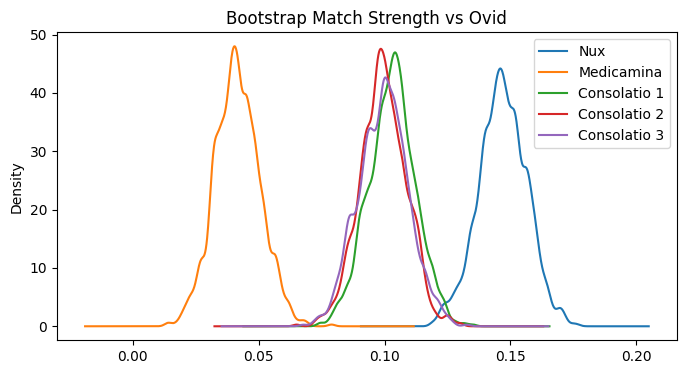

In [179]:
df = pd.DataFrame.from_dict(
    results
)
df[df.columns[~df.columns.str.startswith('Ibis')]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8,4),
    title="Bootstrap Match Strength vs Ovid",
)

<Axes: title={'center': 'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

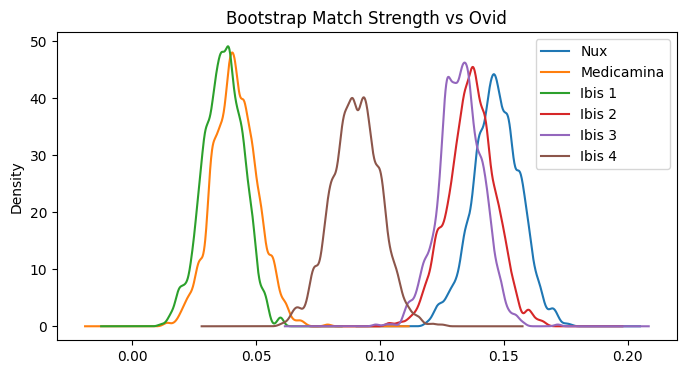

In [180]:
df[df.columns[~df.columns.str.startswith('Consolatio')]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8,4),
    title="Bootstrap Match Strength vs Ovid",
)

In [181]:
for poem, ary in results.items():   
    print(f"{poem:<15}> Percent doubt: {sp.stats.percentileofscore(ary, 0):.2f}")

Nux            > Percent doubt: 0.00
Medicamina     > Percent doubt: 0.00
Consolatio 1   > Percent doubt: 0.00
Consolatio 2   > Percent doubt: 0.00
Consolatio 3   > Percent doubt: 0.00
Ibis 1         > Percent doubt: 0.00
Ibis 2         > Percent doubt: 0.00
Ibis 3         > Percent doubt: 0.00
Ibis 4         > Percent doubt: 0.00


In [182]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [183]:
dff = df.T
dff.reset_index(inplace=True)
tst = dff.melt(id_vars=['index'])
tst['cons'] = tst['index'].str.startswith('Cons')


Picking joint bandwidth of 0.00206


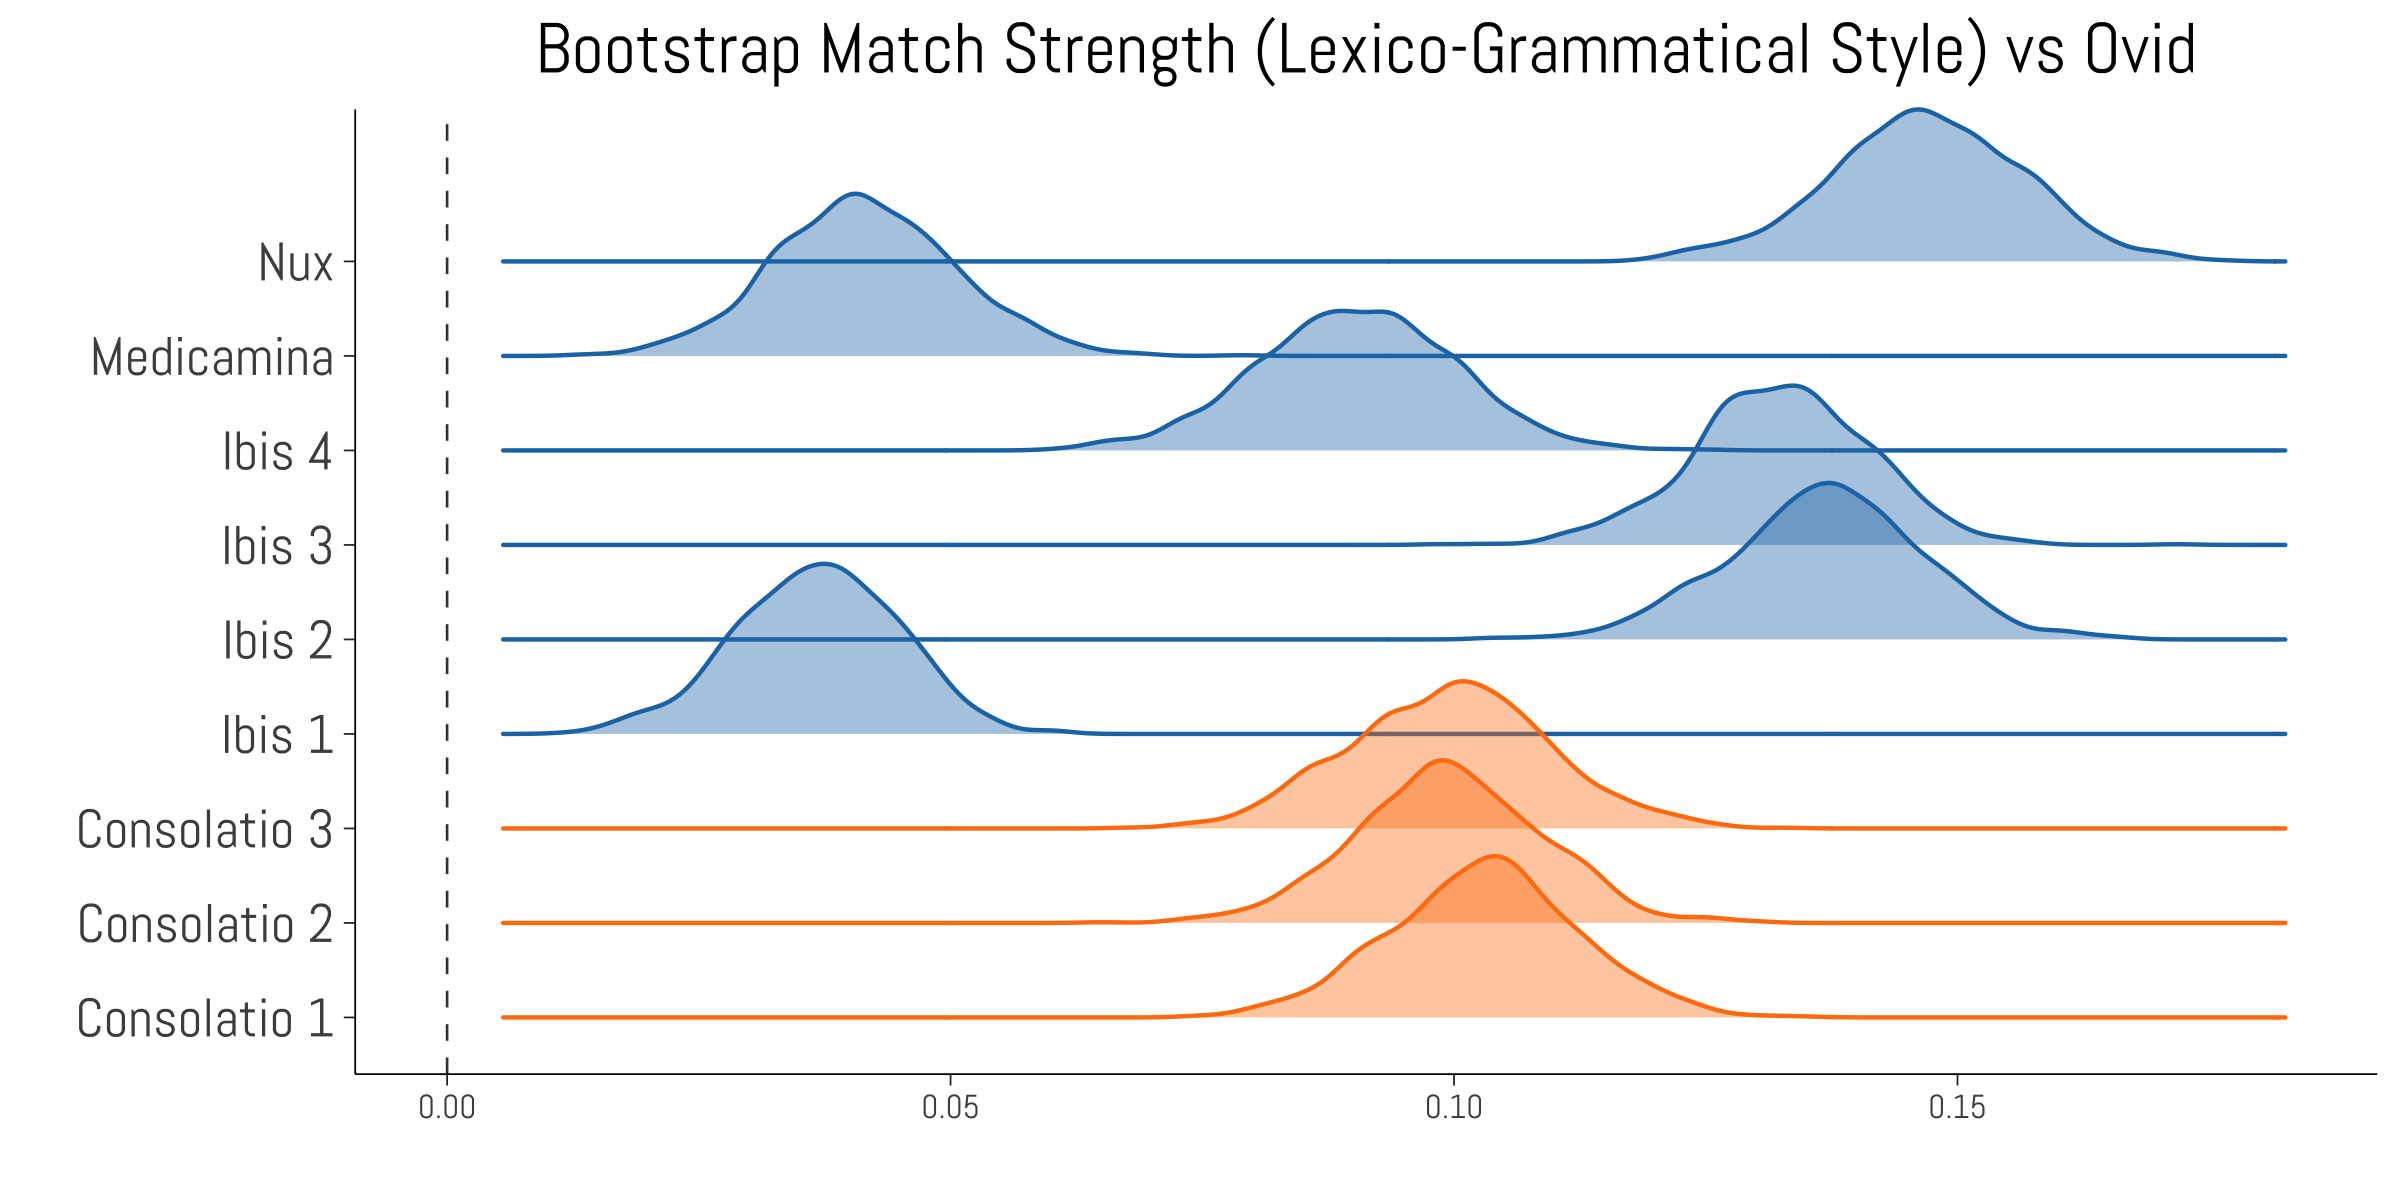

In [185]:
%%R -i tst -h 4 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"

ggplot(data=tst,aes(value,y=index,fill=cons,color=cons)) +
coord_cartesian(clip = "off") +

# Voronoi tesselation for everything
ggridges::stat_density_ridges(
    quantile_lines = FALSE, quantiles = 2, 
    alpha = .4, size = 0.5,
) +
geom_vline(xintercept=0, colour='grey25', linetype='dashed', size=0.3) +
scale_y_discrete() +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Lexico-Grammatical Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=17, family="fnt"),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    axis.text.x=element_text(size=8, family="fnt"),
    axis.text.y=element_text(size=13, family="fnt"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    #text=element_text(size=16, family="fnt"),
)

# fn <- "../paper/figures/ele_ngrams_tsne.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)
